Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


### Initialization SparkSession

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('Streaming').getOrCreate()

### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [4]:
from pyspark.sql.functions import *
from pyspark.sql import types

### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using rate source. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [22]:
initDF = spark.readStream.format('rate').option('rowsPerSecond', 1).load()

### Check if DataFrame is streaming or Not.


In [23]:
initDF.isStreaming

True

### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


### Output

In [24]:
initDF = initDF.withColumn('replica_col', initDF['value']+1)

### Our Second streaming using rate source

### Create Streaming DataFrame

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [30]:
df_socket = spark.readStream.format('socket')\
                        .option('host', 'localhost').option('port', 9999)\
                        .option('rowsPerSecond', 1).load()

In [31]:
df_socket.isStreaming

True

### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [36]:
df_count = df_socket.agg(count('value').alias('count_value '))

In [37]:
df_count.printSchema()

root
 |-- count_value : long (nullable = false)



#### to check nc -lk 9999


### Input Sources — File

Schema Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [43]:
data_dir = 'Data'
my_schema = 'Date STRING, Open DOUBLE, High DOUBLE, Low DOUBLE, Close DOUBLE, Volume INT, Name STRING'

In [44]:
df_data = spark.readStream.format("csv")\
                .schema(my_schema)\
                .load(data_dir)

In [45]:
df_name = df_data.select('Name')

In [51]:
query = df_name.writeStream.outputMode('append')\
                    .format('console')\
                    .option('truncate', False)\
                    .start()

In [ ]:
query.awaitTermination()     ## works well !

In [53]:
query.stop()

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [93]:
df = spark.readStream.format("csv")\
                .option('maxFilesPerTrigger', 2)\
                .schema(my_schema)\
                .load(data_dir)

df_data = df.withColumn('getFileName', df['Name']) 

df_new = df_data.withColumn('newDate', to_timestamp(df_data['Date'], 'yyyy-MM-dd'))\
                                .drop(df_data['Date']) ## to timestamp

df_final = df_new.withColumn('Year', year(df_new['newDate'])) ## extract yea

In [94]:
df_final.printSchema()

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- getFileName: string (nullable = true)
 |-- newDate: timestamp (nullable = true)
 |-- Year: integer (nullable = true)



#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [95]:
df_max_high = df_final.groupBy(['Name', 'Year']).agg(max('High'))

Can you build same transformation by Sql? 

In [96]:
df.createOrReplaceTempView('temp_view')

In [97]:
df_google = spark.sql('select * from temp_view where Name="GOOGL"')

#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [89]:
query = df_max_high.writeStream.outputMode('update')\
                            .format('console')\
                            .option('truncate', False)\
                            .start()

In [ ]:
query.awaitTermination()     ## works well !

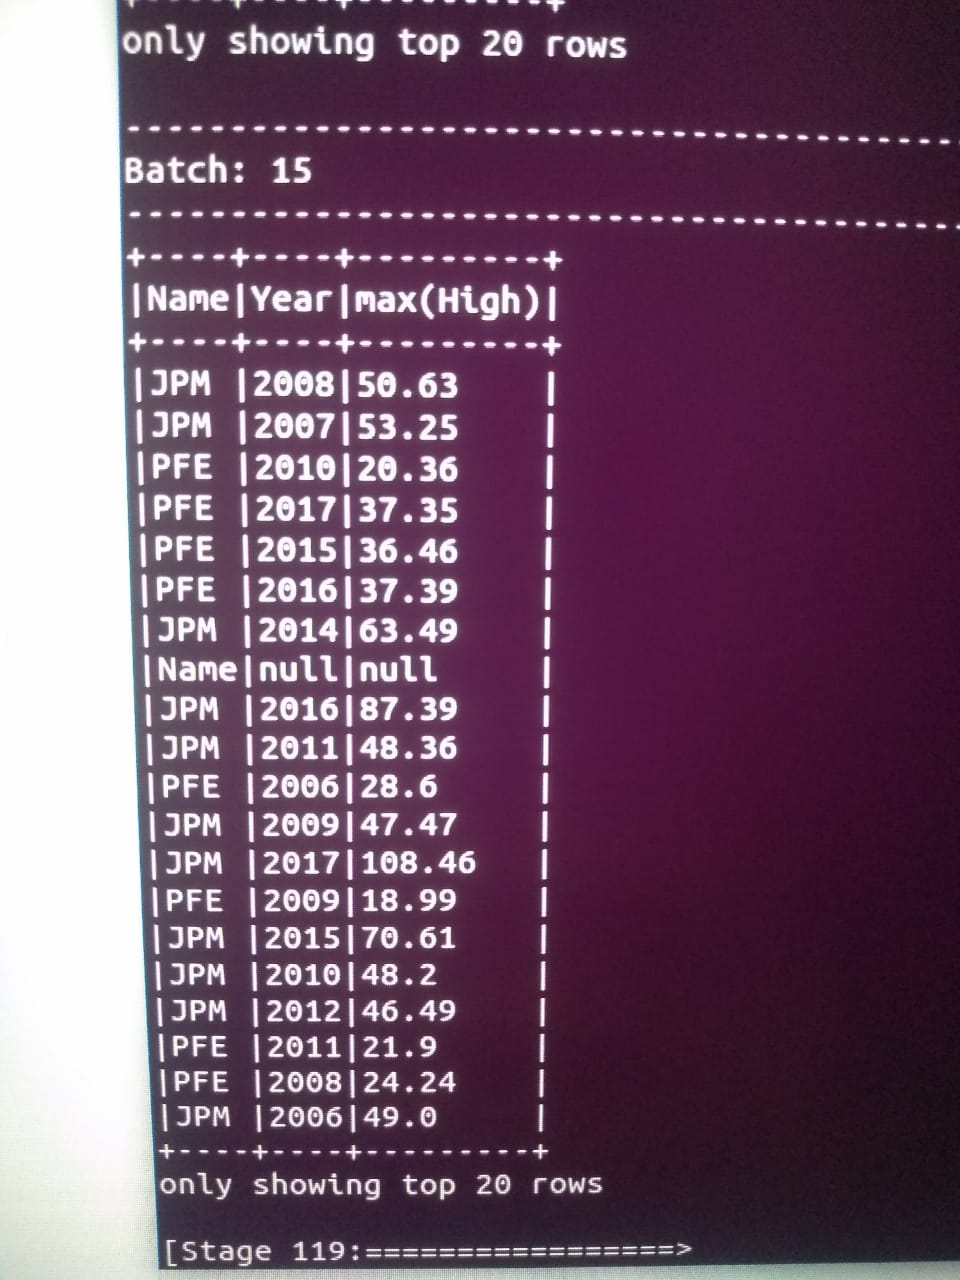

In [91]:
query.stop()

# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [102]:
df = spark.readStream.format("csv")\
                .option('maxFilesPerTrigger', 2)\
                .schema(my_schema)\
                .load(data_dir)

df_new = df_data.withColumn('current_timestamp', to_timestamp(df_data['Date'], 'yyyy-MM-dd'))


df_final = df_new.select(['Name', 'Date', 'Open', 'High', 'Low'])\
                            .groupBy(['Name', 'Date'])\
                            .agg(avg('Open'), avg('High'), avg('Low'))

### Checkpoints

In [106]:
check_dir = "check_dir_1"

query = df_final.writeStream.outputMode('complete')\
                            .format('console')\
                            .trigger(processingTime='1 second')\
                            .option('checkpointLocation', check_dir)\
                            .option('truncate', False)\
                            .start()

In [ ]:
query.awaitTermination()  ## works well !

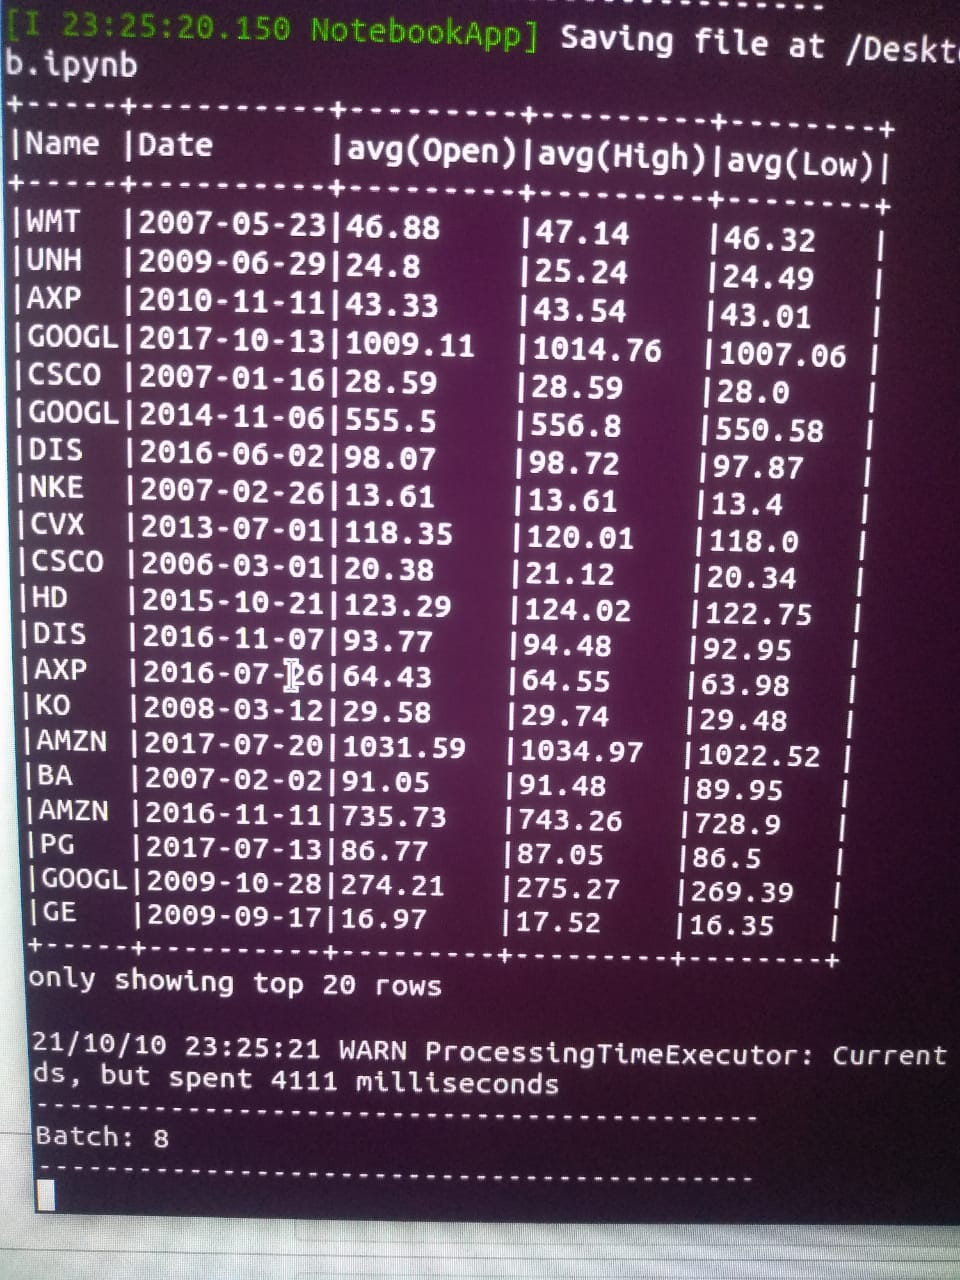

In [108]:
query.stop()

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [111]:
check_dir = "check_dir_2"

query = df_final.writeStream.outputMode('complete')\
                            .format('console')\
                            .trigger(processingTime='1 second')\
                            .option('checkpointLocation', check_dir)\
                            .option('truncate', False)\
                            .start()

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

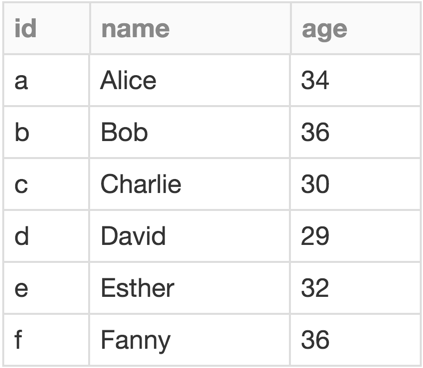

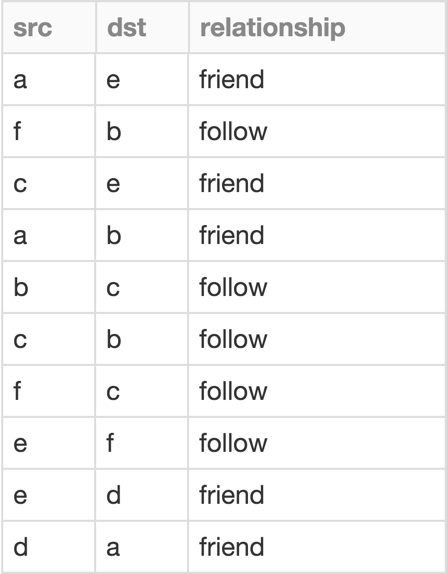

### Create a GraphFrame from vertex and edge DataFrames

### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

Then, the connected components can easily be computed with the connectedComponents-function.


## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph